In [1]:
import sys; sys.path.append('/home/clair/wwa'); from wwa import *

#### **Prep time series for fitting in R**

In [2]:
# Daily max temperatures
da = decode_times(xr.open_dataset("../../Data/era5_tmax_daily_eu_-10-20E_35-55N_su.62f4b5a82fde776a4c64f0ca33646aa0.info_12_max_70.nc", decode_times = False)).max_tmax
lsm = xr.open_dataset("../../Data/era5_000000_lsm_eu.nc").squeeze(drop = True).sel(longitude = da.lon, latitude = da.lat).lsm
da = da.where(lsm >= 0.5).dropna("lat", "all").dropna("lon", "all").dropna("time", "all")

# flatten January maxima into DataFrame for processing in R
da_jan = da.groupby("time.month")[1]
da_jan = da_jan.assign_coords(time = da_jan.time.dt.year)
da_jan.stack(xy = ["lat", "lon"]).to_pandas().to_csv("era5_Jan-tmax_flattened.csv")

# also July data, for direct comparison of change in summer vs winter heatwaves
da_jul = da.groupby("time.month")[7]
da_jul = da_jul.assign_coords(time = da_jul.time.dt.year)
da_jul.stack(xy = ["lat", "lon"]).to_pandas().to_csv("era5_Jul-tmax_flattened.csv")

In [11]:
# Daily min temperatures
da = decode_times(xr.open_dataset("../../Data/era5_tmin_daily_eu_extended_-10-20E_35-55N_su.62f4b5a82fde776a4c64f0ca33646aa0.info_12_max_70.nc", decode_times = False)).max_tmin
lsm = xr.open_dataset("../../Data/era5_000000_lsm_eu.nc").squeeze(drop = True).sel(longitude = da.lon, latitude = da.lat).lsm
da = da.where(lsm >= 0.5).dropna("lat", "all").dropna("lon", "all").dropna("time", "all")

# flatten January maxima into DataFrame for processing in R
da_jan = da.groupby("time.month")[1]
da_jan = da_jan.assign_coords(time = da_jan.time.dt.year)
da_jan.stack(xy = ["lat", "lon"]).to_pandas().to_csv("fitted-models/era5_Jan-tmin_flattened.csv")

# also July data, for direct comparison of change in summer vs winter heatwaves
da_jul = da.groupby("time.month")[7]
da_jul = da_jul.assign_coords(time = da_jul.time.dt.year)
da_jul.stack(xy = ["lat", "lon"]).to_pandas().to_csv("fitted-models/era5_Jul-tmin_flattened.csv")

In [62]:
# ML estimation is carried out in R

#### **Plots of fitted model parameters**

In [2]:
# load fitted models, reshape into dataset for easier plotting

lsm = xr.open_dataset("../../Data/era5_000000_lsm_eu.nc").squeeze(drop = True).sel(longitude = slice(-10,20), latitude = slice(55,35)).lsm.rename(longitude = "lon", latitude = "lat")

jan_tmax = reshape_df("fitted-models/era5-eu_tx1x-Jan_shift_ml-gev-ests.csv", lsm)
jan_tmin = reshape_df("fitted-models/era5-eu_tn1x-Jan_shift_ml-gev-ests.csv", lsm)

Text(0.5, 0.98, 'Fitted trend in warmest January nights (max_tmin)')

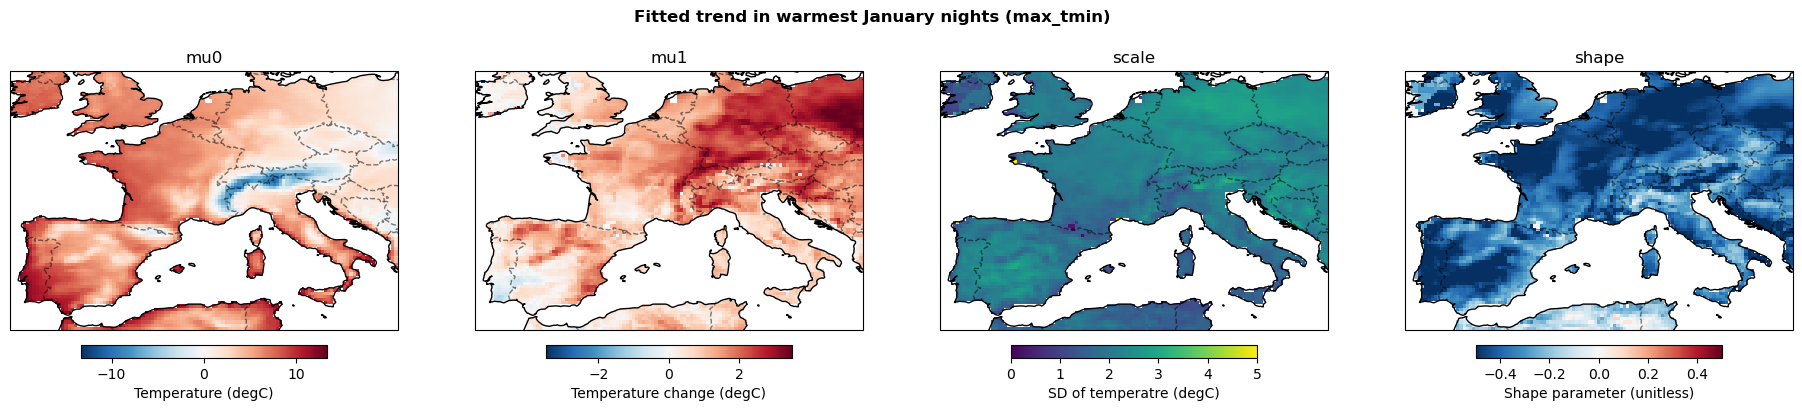

In [7]:
fig, axs = plt.subplots(ncols = 4, figsize = (23,4), dpi = 100, subplot_kw = {"projection" : cartopy.crs.PlateCarree()})

cbar_kwargs = {"location" : "bottom", "fraction" : 0.04, "pad" : 0.05, "shrink" : 0.85}

cb0 = jan_tmin.mu0.plot(ax = axs[0], add_colorbar = False)
plt.colorbar(cb0, ax = axs[0], label = "Temperature (degC)", **cbar_kwargs); axs[0].set_title("mu0")

cb1 = jan_tmin.mu1.plot(ax = axs[1], add_colorbar = False, vmin = -3.5, vmax = 3.5, cmap = "RdBu_r")
plt.colorbar(cb1, ax = axs[1], label = "Temperature change (degC)", **cbar_kwargs); axs[1].set_title("mu1")

cb2 = jan_tmin.sigma0.plot(ax = axs[2], add_colorbar = False, vmin = 0, vmax = 5)
plt.colorbar(cb2, ax = axs[2], label = "SD of temperatre (degC)", **cbar_kwargs); axs[2].set_title("scale")

cb3 = jan_tmin.shape.plot(ax = axs[3], add_colorbar = False, vmin = -0.5, cmap = "RdBu_r")
plt.colorbar(cb3, ax = axs[3], label = "Shape parameter (unitless)", **cbar_kwargs); axs[3].set_title("shape")

for ax in axs:
    ax.coastlines()
    ax.add_feature(cartopy.feature.BORDERS, ls = "--", alpha = 0.5)
    
plt.suptitle("Fitted trend in warmest January nights (max_tmin)", fontweight = "bold")

Text(0.5, 0.98, 'Fitted trend in warmest January days (max_tmax)')

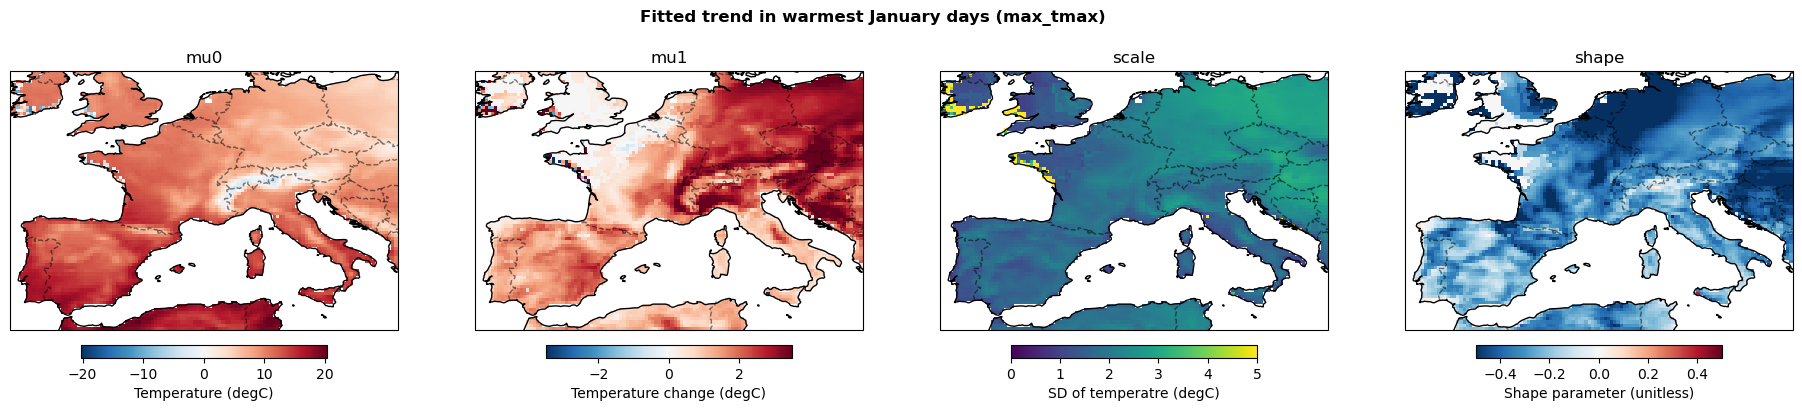

In [8]:
fig, axs = plt.subplots(ncols = 4, figsize = (23,4), dpi = 100, subplot_kw = {"projection" : cartopy.crs.PlateCarree()})

cbar_kwargs = {"location" : "bottom", "fraction" : 0.04, "pad" : 0.05, "shrink" : 0.85}

cb0 = jan_tmax.mu0.plot(ax = axs[0], add_colorbar = False)
plt.colorbar(cb0, ax = axs[0], label = "Temperature (degC)", **cbar_kwargs); axs[0].set_title("mu0")

cb1 = jan_tmax.mu1.plot(ax = axs[1], add_colorbar = False, vmin = -3.5, vmax = 3.5, cmap = "RdBu_r")
plt.colorbar(cb1, ax = axs[1], label = "Temperature change (degC)", **cbar_kwargs); axs[1].set_title("mu1")

cb2 = jan_tmax.sigma0.plot(ax = axs[2], add_colorbar = False, vmin = 0, vmax = 5)
plt.colorbar(cb2, ax = axs[2], label = "SD of temperatre (degC)", **cbar_kwargs); axs[2].set_title("scale")

cb3 = jan_tmax.shape.plot(ax = axs[3], add_colorbar = False, vmin = -0.5, cmap = "RdBu_r")
plt.colorbar(cb3, ax = axs[3], label = "Shape parameter (unitless)", **cbar_kwargs); axs[3].set_title("shape")

for ax in axs:
    ax.coastlines()
    ax.add_feature(cartopy.feature.BORDERS, ls = "--", alpha = 0.5)
    
plt.suptitle("Fitted trend in warmest January days (max_tmax)", fontweight = "bold")

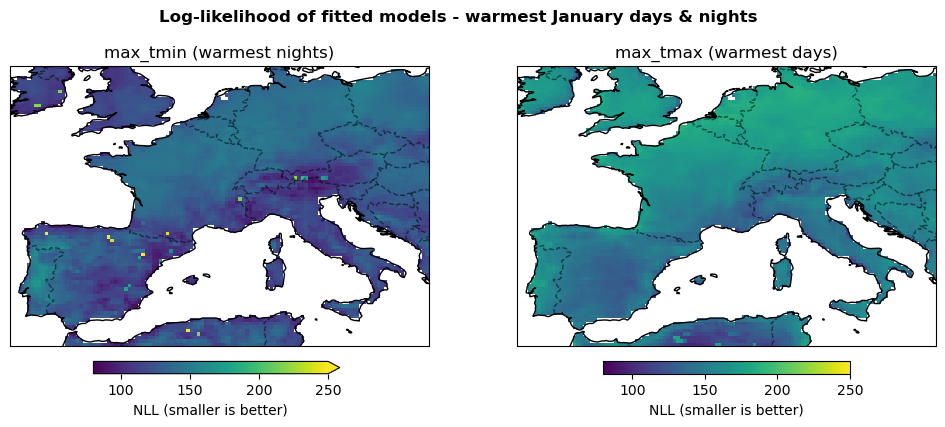

In [190]:
fig, axs = plt.subplots(ncols = 2, figsize = (12,4), dpi = 100, subplot_kw = {"projection" : cartopy.crs.PlateCarree()})

kwargs = {"vmin" : 80, "vmax" : 250, "cbar_kwargs" : {"location" : "bottom", "fraction" : 0.04, "pad" : 0.05, "shrink" : 0.85, "label" : "NLL (smaller is better)"}}

jan_tmin.nll.plot(ax = axs[0], **kwargs)
jan_tmax.nll.plot(ax = axs[1], **kwargs)

axs[0].set_title("max_tmin (warmest nights)")
axs[1].set_title("max_tmax (warmest days)")

plt.suptitle("Log-likelihood of fitted models - warmest January days & nights", fontweight = "bold", y = 1.02)

for ax in axs:
    ax.coastlines()
    ax.add_feature(cartopy.feature.BORDERS, ls = "--", alpha = 0.5)

Text(0.5, 0.98, 'Exceedance probabilities & return periods (max_tmin, January nightly temperatures)')

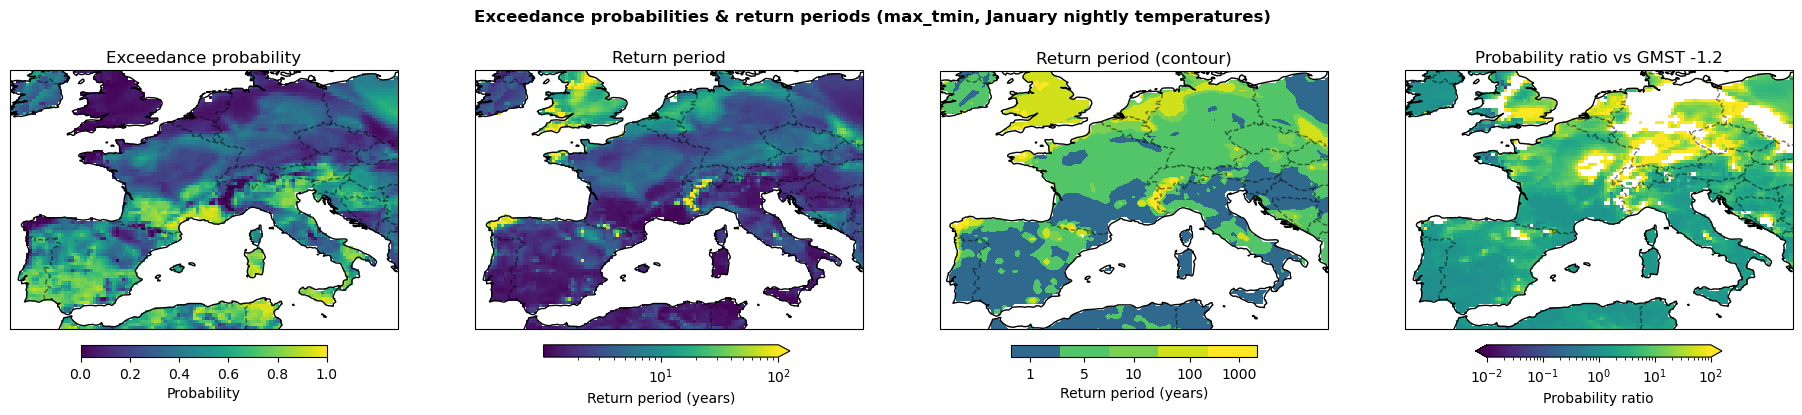

In [192]:
fig, axs = plt.subplots(ncols = 4, figsize = (23,4), dpi = 100, subplot_kw = {"projection" : cartopy.crs.PlateCarree()})

cbar_kwargs = {"location" : "bottom", "fraction" : 0.04, "pad" : 0.05, "shrink" : 0.85}

jan_tmin.ep.plot(ax = axs[0], vmin = 0, vmax = 1, cbar_kwargs = cbar_kwargs | {"label" : "Probability"}); axs[0].set_title("Exceedance probability")

jan_tmin.rp.plot(ax = axs[1], vmax = 100, norm = matplotlib.colors.LogNorm(), cbar_kwargs = cbar_kwargs | {"label" : "Return period (years)"}); axs[1].set_title("Return period")

cb2 = axs[2].contourf(jan_tmin.lon, jan_tmin.lat, jan_tmin.rp, vmax = 100, norm = matplotlib.colors.LogNorm(), levels = [10e-4,2.5,7.5,12.5,150,1500])
plt.colorbar(cb2, ax = axs[2], label = "Return period (years)", extend = "max", **cbar_kwargs, ticks = [1,5,10,100,1000]); axs[2].set_title("Return period (contour)")

jan_tmin.pr.plot(ax = axs[3], cbar_kwargs = cbar_kwargs | {"label" : "Probability ratio"}, norm = matplotlib.colors.LogNorm(), vmin = 10e-3, vmax = 10e1); axs[3].set_title("Probability ratio vs GMST -1.2")

for ax in axs:
    ax.coastlines()
    ax.add_feature(cartopy.feature.BORDERS, ls = "--", alpha = 0.5)
    
plt.suptitle("Exceedance probabilities & return periods (max_tmin, January nightly temperatures)", fontweight = "bold")

Text(0.5, 0.98, 'Exceedance probabilities & return periods (max_tmax, January daily temperatures)')

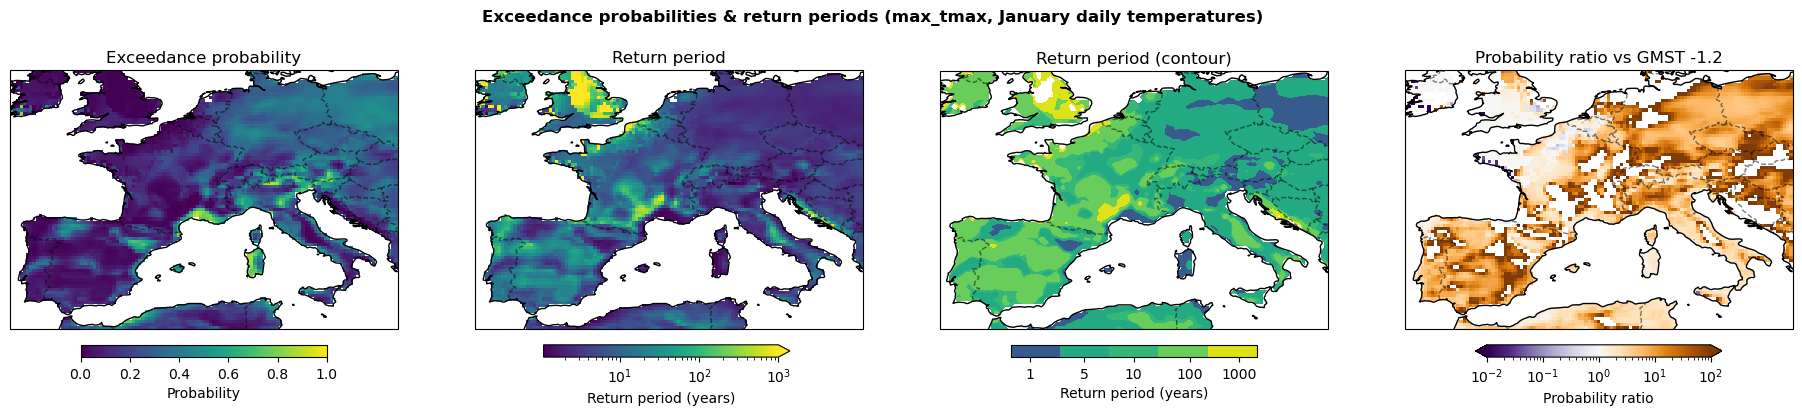

In [111]:
fig, axs = plt.subplots(ncols = 4, figsize = (23,4), dpi = 100, subplot_kw = {"projection" : cartopy.crs.PlateCarree()})

cbar_kwargs = {"location" : "bottom", "fraction" : 0.04, "pad" : 0.05, "shrink" : 0.85}

jan_tmax.ep.plot(ax = axs[0], vmin = 0, vmax = 1, cbar_kwargs = cbar_kwargs | {"label" : "Probability"}); axs[0].set_title("Exceedance probability")
jan_tmax.rp.plot(ax = axs[1], vmax = 1000, norm = matplotlib.colors.LogNorm(), cbar_kwargs = cbar_kwargs | {"label" : "Return period (years)"}); axs[1].set_title("Return period")

cb2 = axs[2].contourf(jan_tmax.lon, jan_tmax.lat, jan_tmax.rp, vmax = 1000, norm = matplotlib.colors.LogNorm(), levels = [10e-4,2.5,7.5,12.5,150,1500])
plt.colorbar(cb2, ax = axs[2], label = "Return period (years)", extend = "max", **cbar_kwargs, ticks = [1,5,10,100,1000]); axs[2].set_title("Return period (contour)")

jan_tmax.pr.plot(ax = axs[3], cmap = "PuOr_r", cbar_kwargs = cbar_kwargs | {"label" : "Probability ratio"}, norm = matplotlib.colors.LogNorm(), vmin = 10e-3, vmax = 10e1); axs[3].set_title("Probability ratio vs GMST -1.2")

for ax in axs:
    ax.coastlines()
    ax.add_feature(cartopy.feature.BORDERS, ls = "--", alpha = 0.5)
    
plt.suptitle("Exceedance probabilities & return periods (max_tmax, January daily temperatures)", fontweight = "bold")

Text(0.5, 0.98, 'Observed & expected events (max_tmin, January nightly temperatures)')

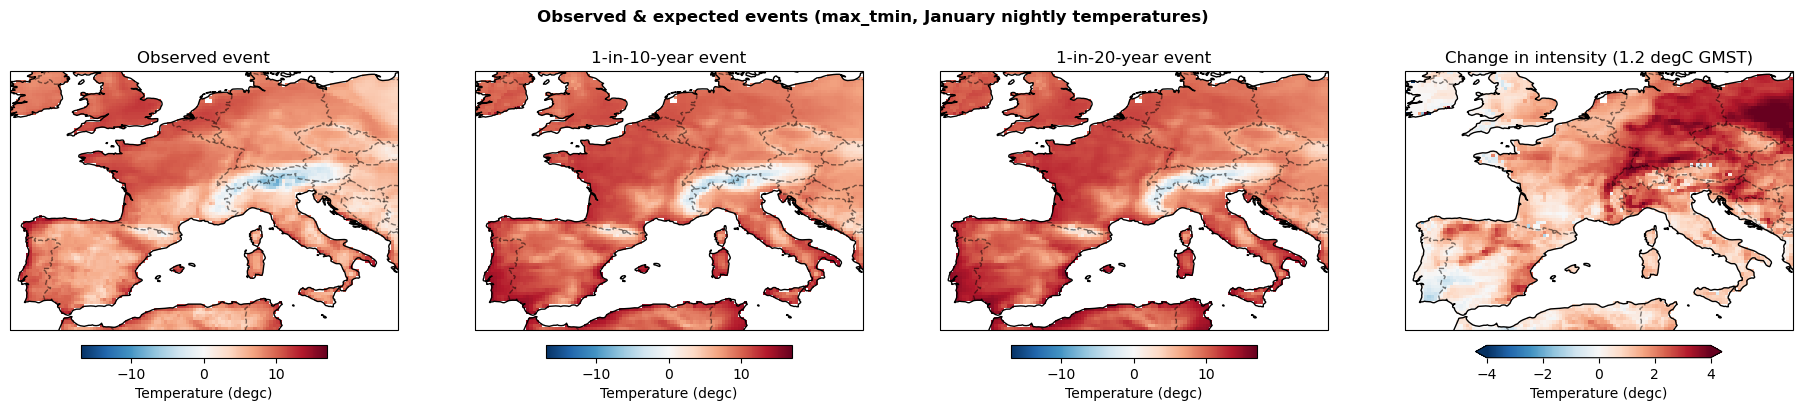

In [117]:
tn = decode_times(xr.open_dataset("../../Data/era5_tmin_daily_eu_extended_-10-20E_35-55N_su.62f4b5a82fde776a4c64f0ca33646aa0.info_12_max_70.nc", decode_times = False)).max_tmin.where(lsm >= 0.5)

fig, axs = plt.subplots(ncols = 4, figsize = (23,4), dpi = 100, subplot_kw = {"projection" : cartopy.crs.PlateCarree()})

cbar_kwargs = {"location" : "bottom", "fraction" : 0.04, "pad" : 0.05, "shrink" : 0.85, "label" : "Temperature (degc)"}
vlims = {"vmax" : 17}

tn.groupby("time.month")[1].isel(time = -1).plot(ax = axs[0], cbar_kwargs = cbar_kwargs, **vlims); axs[0].set_title("Observed event")
jan_tmin.rl10.plot(ax = axs[1], **vlims, cmap = "RdBu_r", cbar_kwargs = cbar_kwargs); axs[1].set_title("1-in-10-year event")
jan_tmin.rl20.plot(ax = axs[2], **vlims, cmap = "RdBu_r", cbar_kwargs = cbar_kwargs); axs[2].set_title("1-in-20-year event")
jan_tmin.delta_I.plot(ax = axs[3], vmax = 4, cbar_kwargs = cbar_kwargs); axs[3].set_title("Change in intensity (1.2 degC GMST)")

for ax in axs:
    ax.coastlines()
    ax.add_feature(cartopy.feature.BORDERS, ls = "--", alpha = 0.5)
    
plt.suptitle("Observed & expected events (max_tmin, January nightly temperatures)", fontweight = "bold")

Text(0.5, 0.98, 'Observed & expected events (max_tmax, January daily temperatures)')

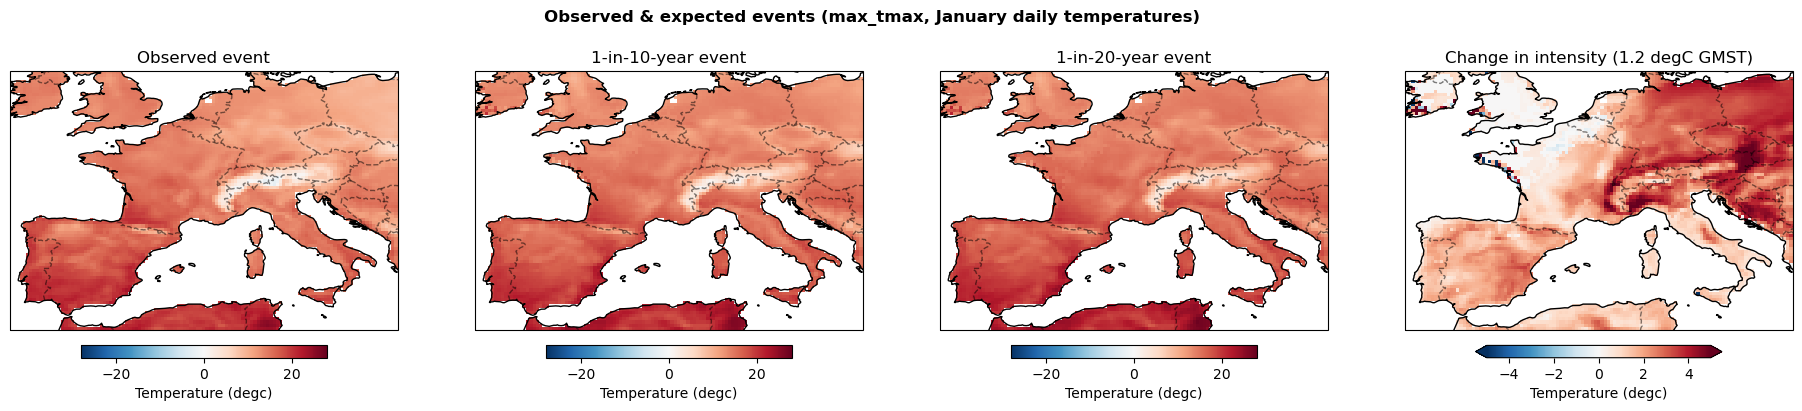

In [123]:
tx = decode_times(xr.open_dataset("../../Data/era5_tmax_daily_eu_-10-20E_35-55N_su.62f4b5a82fde776a4c64f0ca33646aa0.info_12_max_70.nc", decode_times = False)).max_tmax.where(lsm >= 0.5)

fig, axs = plt.subplots(ncols = 4, figsize = (23,4), dpi = 100, subplot_kw = {"projection" : cartopy.crs.PlateCarree()})

cbar_kwargs = {"location" : "bottom", "fraction" : 0.04, "pad" : 0.05, "shrink" : 0.85, "label" : "Temperature (degc)"}
vlims = {"vmax" : 28, "vmin" : -28, "cmap" : "RdBu_r"}

tx.groupby("time.month")[1].isel(time = -1).plot(ax = axs[0], cbar_kwargs = cbar_kwargs, **vlims); axs[0].set_title("Observed event")
jan_tmax.rl10.plot(ax = axs[1], **vlims, cbar_kwargs = cbar_kwargs); axs[1].set_title("1-in-10-year event")
jan_tmax.rl20.plot(ax = axs[2], **vlims, cbar_kwargs = cbar_kwargs); axs[2].set_title("1-in-20-year event")
jan_tmax.delta_I.plot(ax = axs[3], vmax = 5, cbar_kwargs = cbar_kwargs); axs[3].set_title("Change in intensity (1.2 degC GMST)")

for ax in axs:
    ax.coastlines()
    ax.add_feature(cartopy.feature.BORDERS, ls = "--", alpha = 0.5)
    
plt.suptitle("Observed & expected events (max_tmax, January daily temperatures)", fontweight = "bold")

Text(0.5, 0.98, 'Change in intensity of 2022 event under 1.2degC GMST change')

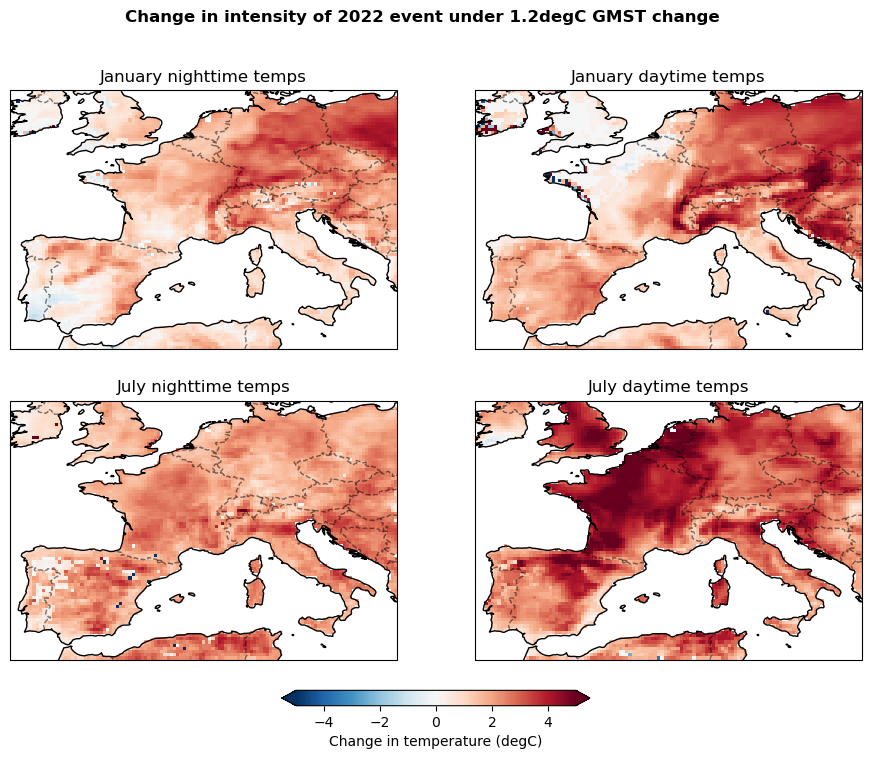

In [148]:
jul_tmax = reshape_df("fitted-models/era5-eu_tx1x-Jul_shift_ml-gev-ests.csv", lsm)
jul_tmin = reshape_df("fitted-models/era5-eu_tn1x-Jul_shift_ml-gev-ests.csv", lsm)

fig, axs = plt.subplots(ncols = 2, nrows = 2, figsize = (11,8), dpi = 100, subplot_kw = {"projection" : cartopy.crs.PlateCarree()})

cbar_kwargs = {"location" : "bottom", "fraction" : 0.025, "pad" : 0.05, "shrink" : 0.85, "label" : "Change in temperature (degC)"}
int_kws = {"add_colorbar" : False, "vmax" : 5}

jan_tmin.delta_I.plot(ax = axs[0,0], **kws); axs[0,0].set_title("January nighttime temps")
jan_tmax.delta_I.plot(ax = axs[0,1], **kws); axs[0,1].set_title("January daytime temps")

jul_tmin.delta_I.plot(ax = axs[1,0], **kws); axs[1,0].set_title("July nighttime temps")
cbar = jul_tmax.delta_I.plot(ax = axs[1,1], **kws); axs[1,1].set_title("July daytime temps")

plt.colorbar(cbar, ax = axs, **cbar_kwargs, extend = "both")

for i in range(2):
    for ax in axs[i,:]:
        ax.coastlines()
        ax.add_feature(cartopy.feature.BORDERS, ls = "--", alpha = 0.5)
        
plt.suptitle("Change in intensity of 2022 event under 1.2degC GMST change", fontweight = "bold")

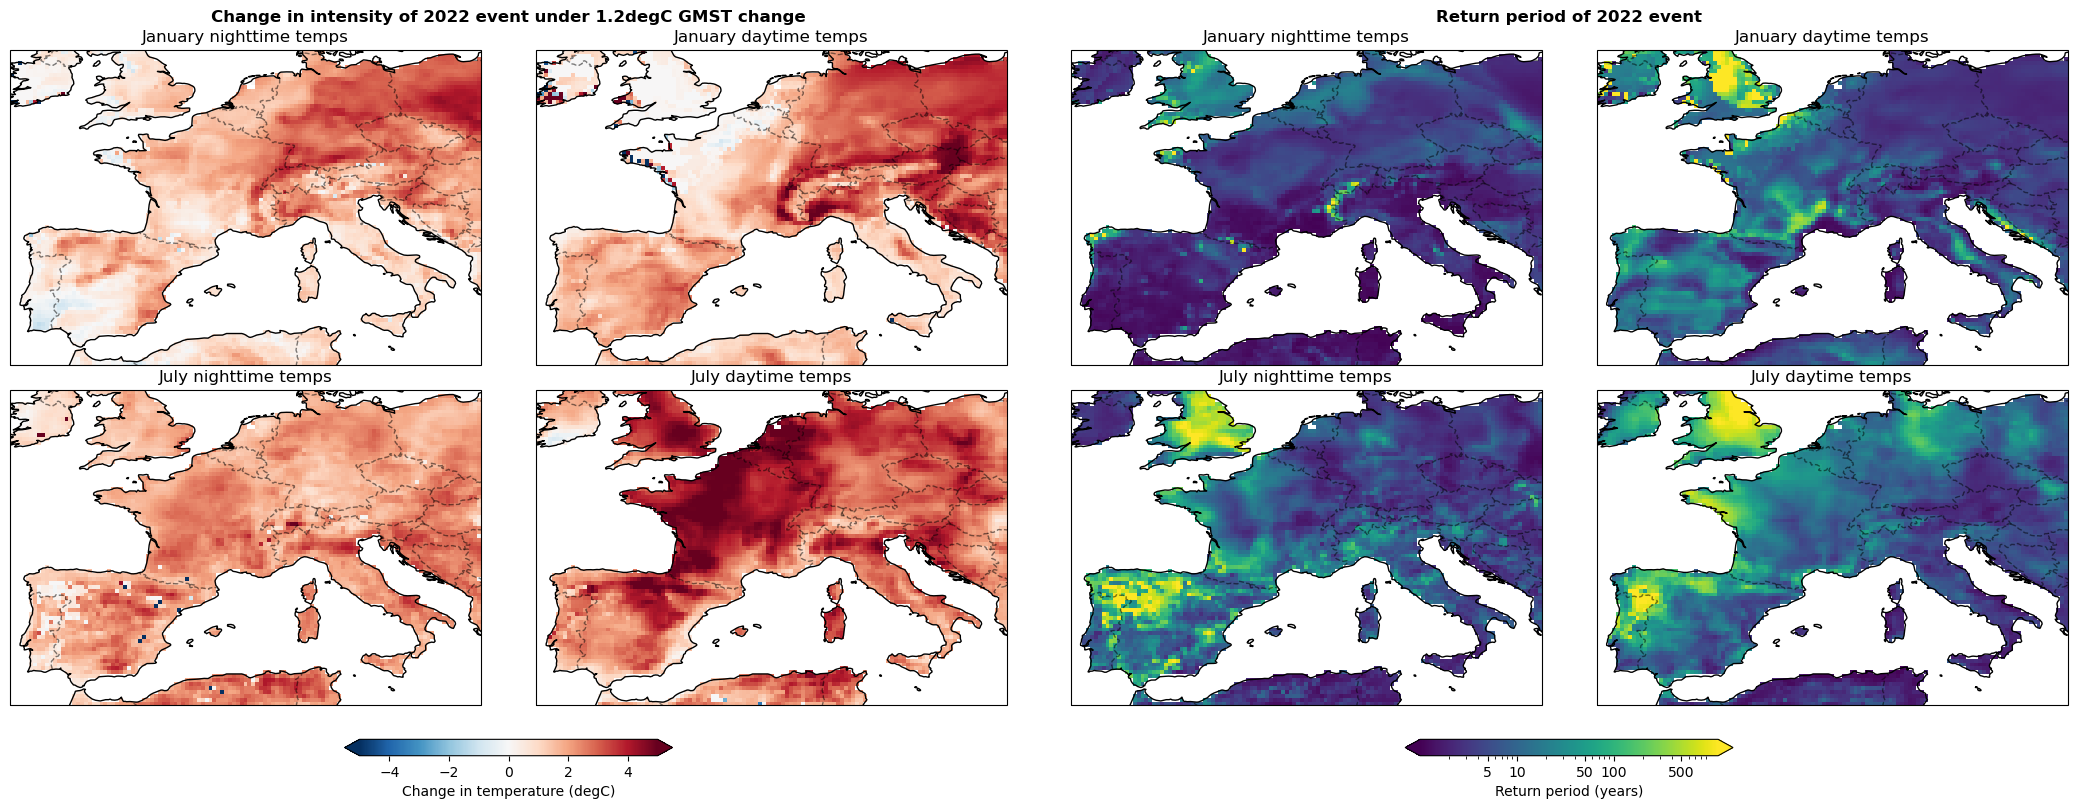

In [189]:
fig = plt.figure(constrained_layout = True, figsize = (21,8), dpi = 100)
sfig = fig.subfigures(nrows = 1, ncols = 2)

cbar_kwargs = {"location" : "bottom", "fraction" : 0.025, "pad" : 0.05, "shrink" : 0.85}
int_kwargs = {"add_colorbar" : False, "vmax" : 5}
rp_kwargs = {"add_colorbar" : False,  "norm" : matplotlib.colors.LogNorm(), "vmin" : 1, "vmax" : 1200}

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

sfig[0].suptitle("Change in intensity of 2022 event under 1.2degC GMST change", fontweight = "bold")
axs = sfig[0].subplots(ncols = 2, nrows = 2, subplot_kw = {"projection" : cartopy.crs.PlateCarree()})

jan_tmin.delta_I.plot(ax = axs[0,0], **int_kwargs); axs[0,0].set_title("January nighttime temps")
jan_tmax.delta_I.plot(ax = axs[0,1], **int_kwargs); axs[0,1].set_title("January daytime temps")

jul_tmin.delta_I.plot(ax = axs[1,0], **int_kwargs); axs[1,0].set_title("July nighttime temps")
int_cbar = jul_tmax.delta_I.plot(ax = axs[1,1], **int_kwargs); axs[1,1].set_title("July daytime temps")

plt.colorbar(int_cbar, ax = axs, **cbar_kwargs | {"label" : "Change in temperature (degC)"}, extend = "both")

for i in range(2):
    for ax in axs[i,:]:
        ax.coastlines()
        ax.add_feature(cartopy.feature.BORDERS, ls = "--", alpha = 0.5)
        
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

sfig[1].suptitle("Return period of 2022 event", fontweight = "bold")
axs = sfig[1].subplots(ncols = 2, nrows = 2, subplot_kw = {"projection" : cartopy.crs.PlateCarree()})

jan_tmin.rp.plot(ax = axs[0,0], **rp_kwargs); axs[0,0].set_title("January nighttime temps")
jan_tmax.rp.plot(ax = axs[0,1], **rp_kwargs); axs[0,1].set_title("January daytime temps")
jul_tmin.rp.plot(ax = axs[1,0], **rp_kwargs); axs[1,0].set_title("July nighttime temps")
rp_cbar = jul_tmax.rp.plot(ax = axs[1,1], **rp_kwargs); axs[1,1].set_title("July daytime temps")

plt.colorbar(rp_cbar, ax = axs, **cbar_kwargs, label = "Return period (years)", ticks = [5,10,50,100,500], format = lambda x, _: f"{x}", extend = "both")

for i in range(2):
    for ax in axs[i,:]:
        ax.coastlines()
        ax.add_feature(cartopy.feature.BORDERS, ls = "--", alpha = 0.5)
        
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

plt.savefig("jan-vs-july-hw-change.png")

In [179]:
jan_tmax.nll.argmin()

<xarray.DataArray 'nll' ()>
array(7250)